In [67]:
import sys
sys.path.append('../src')
import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from geoembs.clay import wrapper
import numpy as np
from einops import rearrange, reduce, repeat
from glob import glob
from tqdm import tqdm

In [2]:
METADATA_PATH = '/opt/data/dora/public-data/claymodel-weights/metadata.yaml'
CHECKPOINT_PATH = '/opt/data/dora/public-data/claymodel-weights/clay-v1.5.ckpt'
cw = wrapper.ClayWrapper(metadata_path=METADATA_PATH, checkpoint_path=CHECKPOINT_PATH)


2025-08-09 22:52:10.364 | INFO     | geoembs.clay.wrapper:__init__:23 - using device cpu
2025-08-09 22:52:10.365 | INFO     | geoembs.clay.wrapper:__init__:25 - creating clay model instance
2025-08-09 22:52:16.412 | INFO     | geoembs.clay.wrapper:__init__:43 - loading clay model weights
2025-08-09 22:52:19.719 | INFO     | geoembs.clay.wrapper:__init__:53 - done


In [73]:
chip_files = glob('/opt/data/dora/public-data/chips/*')
len(chip_files)


48313

In [74]:
batch_size = 32

In [71]:
embeddings = []
for i in tqdm(range(0, len(chip_files), batch_size)):
    batch = []
    for ii in range(batch_size):
        with open(chip_files[i+ii],'rb') as f:
            z = pickle.load(f)
        batch.append(z['img'])

    batch = np.transpose(np.r_[batch], (0,3,1,2))
    ez = cw.batch_embeddings(batch)
    for ezi in ez:
        embeddings.append(ezi)
    if i>100: break

  0%|▎                                                                                                 | 4/1510 [02:33<16:01:03, 38.29s/it]


In [72]:
np.r_[embeddings].shape

(160, 1024)

In [64]:
print (batch.sum(axis=1).sum(axis=1).sum(axis=1))
ez = cw.batch_embeddings(batch)
ez.sum(axis=1)

[ 90058528  34216827  91212969 120314173  84592517  74429642  73396939
  20851505  64020576  75061053  73659522  40884371  64616924  77318217
  47537134  66998395  20336354  64159831  62958136  91971426  96902087
  75433605  63519561  94922893  88214550  52645729  77736562  85569740
  31672188  42330601  77368471  43943355]


tensor([-2.0940, -0.2600,  0.3686,  0.1502, -1.8149,  0.4129, -0.6606,  0.7834,
        -1.7922, -1.8825, -0.5208,  0.9091, -0.0886, -0.1744,  1.4948,  0.5986,
         1.8730,  0.5982,  1.5070,  4.1215, -1.3377,  1.0378, -1.7397, -1.9013,
         1.4988, -1.2506, -1.0428, -1.5863,  0.2216, -0.4533, -1.8834, -1.1162])

In [65]:
print (batch.sum(axis=1).sum(axis=1).sum(axis=1))
ez = cw.batch_embeddings(batch)
ez.sum(axis=1)

[ 90058528  34216827  91212969 120314173  84592517  74429642  73396939
  20851505  64020576  75061053  73659522  40884371  64616924  77318217
  47537134  66998395  20336354  64159831  62958136  91971426  96902087
  75433605  63519561  94922893  88214550  52645729  77736562  85569740
  31672188  42330601  77368471  43943355]


tensor([-1.9631,  0.2696,  0.3447,  0.6884, -1.3312,  0.2243, -0.5542,  0.7926,
        -2.1083, -2.2590, -0.3215,  0.7640,  0.0397, -0.0971,  1.4933,  0.7184,
         1.9902,  1.1081,  1.4652,  4.2559, -1.4272,  1.2392, -1.6231, -1.6917,
         1.8283, -1.3502, -0.8359, -1.6616,  0.1505, -0.3124, -1.8798, -1.3003])

In [55]:
_batch = batch[::-1]
print (_batch.sum(axis=1).sum(axis=1).sum(axis=1))
ez = cw.batch_embeddings(_batch)
ez.sum(axis=1)

[ 20851505  73396939  74429642  84592517 120314173  91212969  34216827
  90058528]


tensor([ 0.3181, -0.6067,  0.1763, -1.6307,  0.2818,  0.8569,  0.0228, -2.3430])

In [53]:
ez = cw.batch_embeddings(batch)
ez.sum(axis=1)

In [37]:
ez.shape

torch.Size([8, 1024])

In [38]:
ez.sum(axis=1)

tensor([ 0.6073, -0.4167,  0.4584, -1.1889,  0.5633,  0.2524, -0.1251, -1.6700])

In [32]:
ez.sum(axis=1)

tensor([-2.2522,  0.2723,  0.3423,  0.3995, -1.4187,  0.2972, -0.7413,  0.7809])

In [26]:
self = cw
batch_normalized = np.transpose(
    (np.transpose(batch, [0, 2, 3, 1]) - self.means) / self.stds, [0, 3, 1, 2]
)
batch_normalized.shape

(1, 3, 512, 512)

In [27]:
import torch
x = {
    "pixels": torch.tensor(batch_normalized).type(torch.float),
    "time": torch.zeros([len(batch_normalized),4]),
    "latlon": torch.zeros([len(batch_normalized),4]),
    "gsd": torch.tensor(10.0),
    "waves": torch.tensor([1552.0, 1355.0, 1105.0]),
}  # rgb freqs


In [28]:
with torch.no_grad():
    embeddings_raw, *_ = self.clay_model.model.encoder(x)


In [29]:
{k:v.shape for k,v in x.items()}

{'pixels': torch.Size([1, 3, 512, 512]),
 'time': torch.Size([1, 4]),
 'latlon': torch.Size([1, 4]),
 'gsd': torch.Size([]),
 'waves': torch.Size([3])}

In [17]:
embeddings_raw.shape

torch.Size([4, 1025, 1024])

In [14]:
z = gpd.read_parquet('/opt/data/dora/public-data/consolidated.parquet')
z.head()

,chipset_id,chip_id,season,geometry,lonlat
0,2ebd307bdaafd,00217e53ae025,winter,"POLYGON ((23.505 15.42755, 23.505 15.47379, 23...","[23.528842211411103, 15.450666195202487]"
1,356f2efa4e288,305c4716ab785,fall,"POLYGON ((54.77138 62.73265, 54.77138 62.77865...","[54.821557935421026, 62.755649953351664]"
2,1db1f5fb2866f,0ac172540e823,fall,"POLYGON ((85.51424 26.46238, 85.51424 26.50859...","[85.53991161186431, 26.485483925845262]"
3,16be5dd21ae4c,087a4afcebe35,spring,"POLYGON ((147.82412 64.53943, 147.82412 64.585...","[147.8775275593774, 64.562401914625]"
4,268b8065b9d36,1bacb25ff4da4,winter,"POLYGON ((0.87037 15.94743, 0.87037 15.99368, ...","[0.8942767029818856, 15.970550853338139]"


In [15]:
z.shape

(48313, 5)

In [19]:
fname = '/opt/data/dora/public-data/chips/00217e53ae025.pkl'
with open(fname,'rb') as f:
    z = pickle.load(f)

In [18]:
z.keys()

dict_keys(['chipset_id', 'chip_id', 'season', 'description', 'img', 'geometry', 'image_embedding', 'text_embedding', 'lonlat'])

In [11]:
z['img'].shape, z['image_embedding'].shape, z['text_embedding'].shape, z['lonlat'], z['season']

((512, 512, 3),
 (1024,),
 (1024,),
 (23.528842211411103, 15.450666195202487),
 'winter')

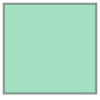

In [9]:
z['geometry']

In [4]:
print (z['description'])

This satellite image depicts a predominantly arid or semi-arid landscape with a complex network of geological and hydrological features.  The overall color palette is dominated by reddish-brown hues, suggesting exposed soil and rock.

**Terrain:**

* **Feature Type:** Dissected plateau/hills
* **Location:** Across the entire image.
* **Size/Extent:** Covers the entire image.
* **Shape and Visual Attributes:** Gently rolling topography with numerous small, incised valleys and ridges.  The terrain appears heavily eroded, with a textured appearance.  Color varies from light reddish-brown in flatter areas to darker reddish-brown on slopes and ridges.
* **Spatial Relationships:** The terrain forms the base upon which all other features are situated.  Drainage channels are incised into the plateau.

* **Feature Type:** Small mesas/buttes (isolated, flat-topped hills)
* **Location:** Several scattered throughout the image, most prominently in the northeast quadrant.
* **Size/Extent:** Small t